# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History




### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.925793382849426

ROC/AUC Score: 0.9257583124191925
              precision    recall  f1-score   support

        Loss       0.92      0.93      0.93      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results

```
Model Score: 0.9225523295070898

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-history_diff-matchup_diff"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col) and not re.search('diff', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all columns that doesn't have diff
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('diff', col)]
    data = data.drop(matchup_columns, axis=1)

    print(f'After: data.shape {data.shape}')
    
    return data
    
X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (44429, 5293)
After: data.shape (44429, 5259)
Before: data.shape (14810, 5293)
After: data.shape (14810, 5259)


In [4]:
[col for col in X_train.columns if re.search('matchup|history', col)]

['p1_history_win_percentage_diff',
 'p1_history_games_won_percentage_diff',
 'p1_history_sets_won_percentage_diff',
 'p1_history_wins_diff',
 'p1_history_losses_diff',
 'p1_matchup_games_diff',
 'p1_matchup_sets_diff',
 'p1_matchup_wins_diff']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6714382174206617

ROC/AUC Score: 0.6715005717219783
              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.67      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4933  2520
Win   2346  5011


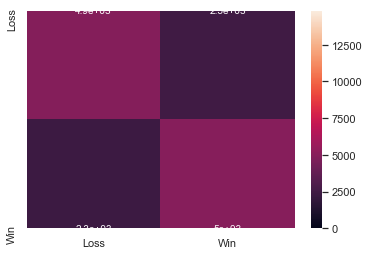

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8343686698176908

ROC/AUC Score: 0.8342737318057188
              precision    recall  f1-score   support

        Loss       0.83      0.85      0.84      7453
         Win       0.84      0.82      0.83      7357

    accuracy                           0.83     14810
   macro avg       0.83      0.83      0.83     14810
weighted avg       0.83      0.83      0.83     14810

      Loss   Win
Loss  6327  1126
Win   1327  6030


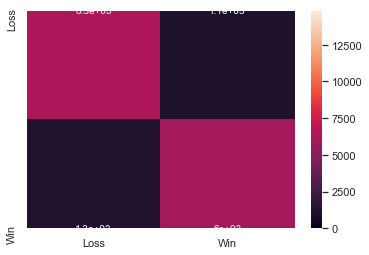

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9225523295070898

ROC/AUC Score: 0.9225390080315006
              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810

      Loss   Win
Loss  6891   562
Win    585  6772


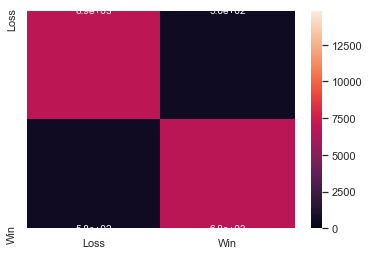

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7760972316002701

ROC/AUC Score: 0.7758794767722137
              precision    recall  f1-score   support

        Loss       0.76      0.81      0.78      7453
         Win       0.79      0.74      0.77      7357

    accuracy                           0.78     14810
   macro avg       0.78      0.78      0.78     14810
weighted avg       0.78      0.78      0.78     14810

      Loss   Win
Loss  6033  1420
Win   1896  5461


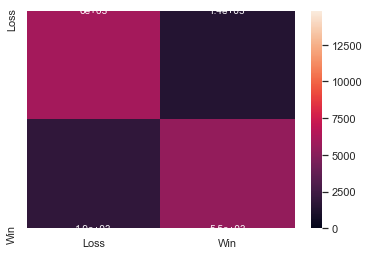

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157           10.77m
         2           1.2579           10.28m
         3           1.2102            9.87m
         4           1.1722            9.75m
         5           1.1405            9.89m
         6           1.1058            9.65m
         7           1.0785            9.52m
         8           1.0558            9.48m
         9           1.0321            9.63m
        10           1.0159            9.54m
        20           0.8899            8.84m
        30           0.8228            7.50m
        40           0.7862            6.50m
        50           0.7597            5.44m
        60           0.7419            4.37m
        70           0.7299            3.25m
        80           0.7146            2.17m
        90           0.6962            1.08m
       100           0.6804            0.00s


Model Score: 0.8522619851451722

ROC/AUC Score: 0.852105207494764
              precision    recall  f1-score   support

        Loss       0.84      0.88      0.86      7453
         Win       0.87      0.83      0.85      7357

    accuracy                           0.85     14810
   macro avg       0.85      0.85      0.85     14810
weighted avg       0.85      0.85      0.85     14810

      Loss   Win
Loss  6531   922
Win   1266  6091


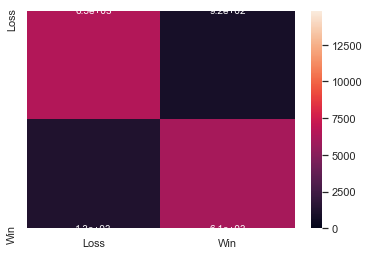

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7492910195813639

ROC/AUC Score: 0.7490611957994169
              precision    recall  f1-score   support

        Loss       0.74      0.78      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5847  1606
Win   2107  5250


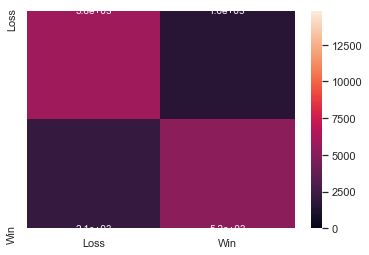

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
73,KNeighborsClassifier,diff-ohe-history_diff-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.834369,0.834274,"{""0"": {""0"": 6327, ""1"": 1327}, ""1"": {""0"": 1126,...","{""Loss"": {""precision"": 0.8266266004703423, ""re...",../models/kneighborsclassifier-1998-2018-diff-...,0.0,0.0,0.0
74,DecisionTreeClassifier,diff-ohe-history_diff-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.922552,0.922539,"{""0"": {""0"": 6891, ""1"": 585}, ""1"": {""0"": 562, ""...","{""Loss"": {""precision"": 0.9217495987158909, ""re...",../models/decisiontreeclassifier-1998-2018-dif...,0.0,0.0,0.0
75,RandomForestClassifier,diff-ohe-history_diff-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.776097,0.775879,"{""0"": {""0"": 6033, ""1"": 1896}, ""1"": {""0"": 1420,...","{""Loss"": {""precision"": 0.7608777903897087, ""re...",../models/randomforestclassifier-1998-2018-dif...,0.0,0.0,0.0
76,GradientBoostingClassifier,diff-ohe-history_diff-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.852262,0.852105,"{""0"": {""0"": 6531, ""1"": 1266}, ""1"": {""0"": 922, ...","{""Loss"": {""precision"": 0.8376298576375529, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,11.0,11.0
77,AdaBoostClassifier,diff-ohe-history_diff-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.749291,0.749061,"{""0"": {""0"": 5847, ""1"": 2107}, ""1"": {""0"": 1606,...","{""Loss"": {""precision"": 0.735101835554438, ""rec...",../models/adaboostclassifier-1998-2018-diff-oh...,0.0,1.0,1.0


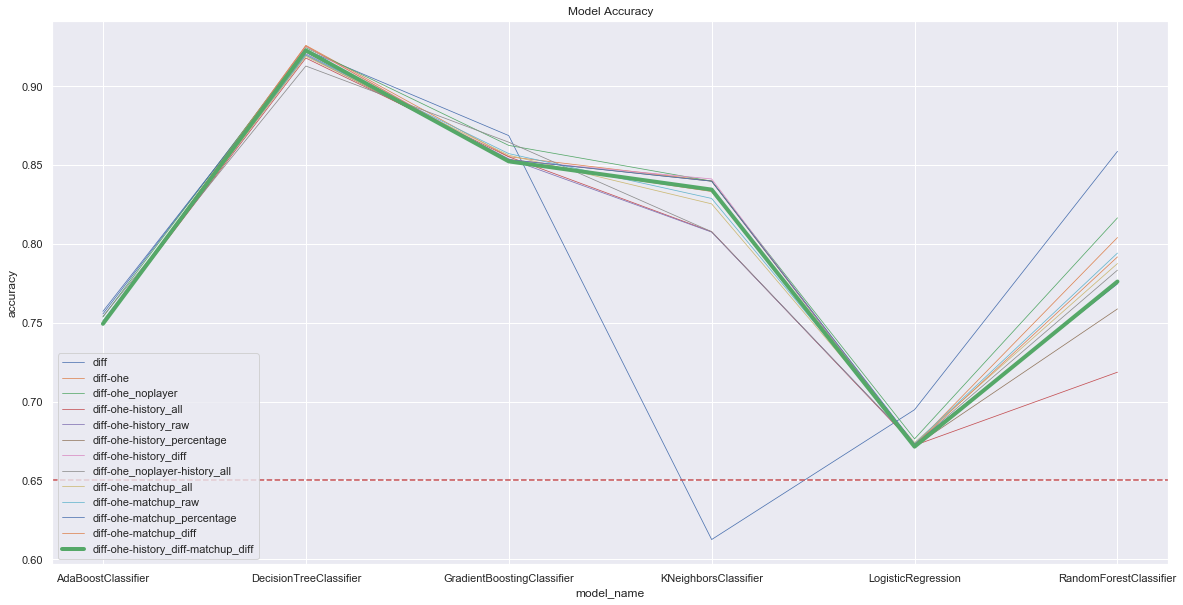

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

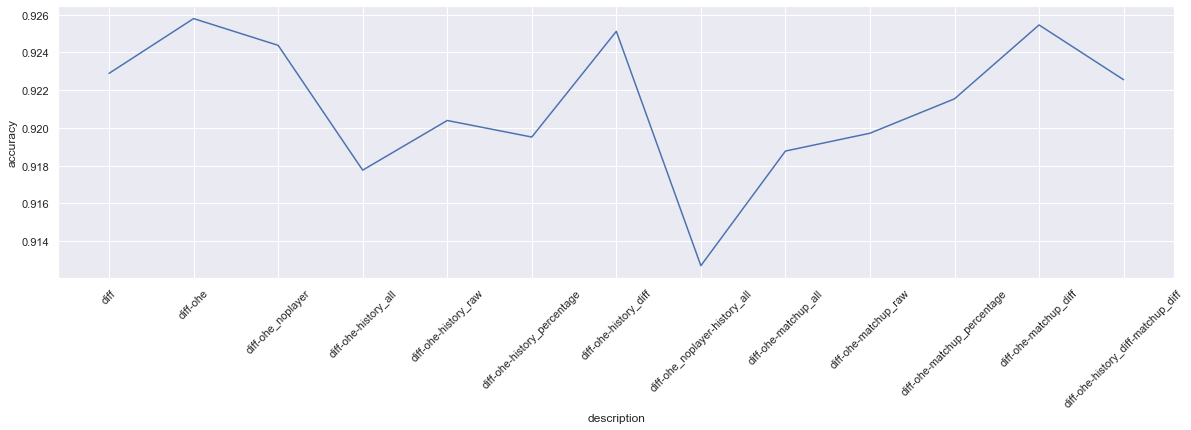

In [31]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
import shap

shap.initjs()

mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)



(2, 14810, 5259)


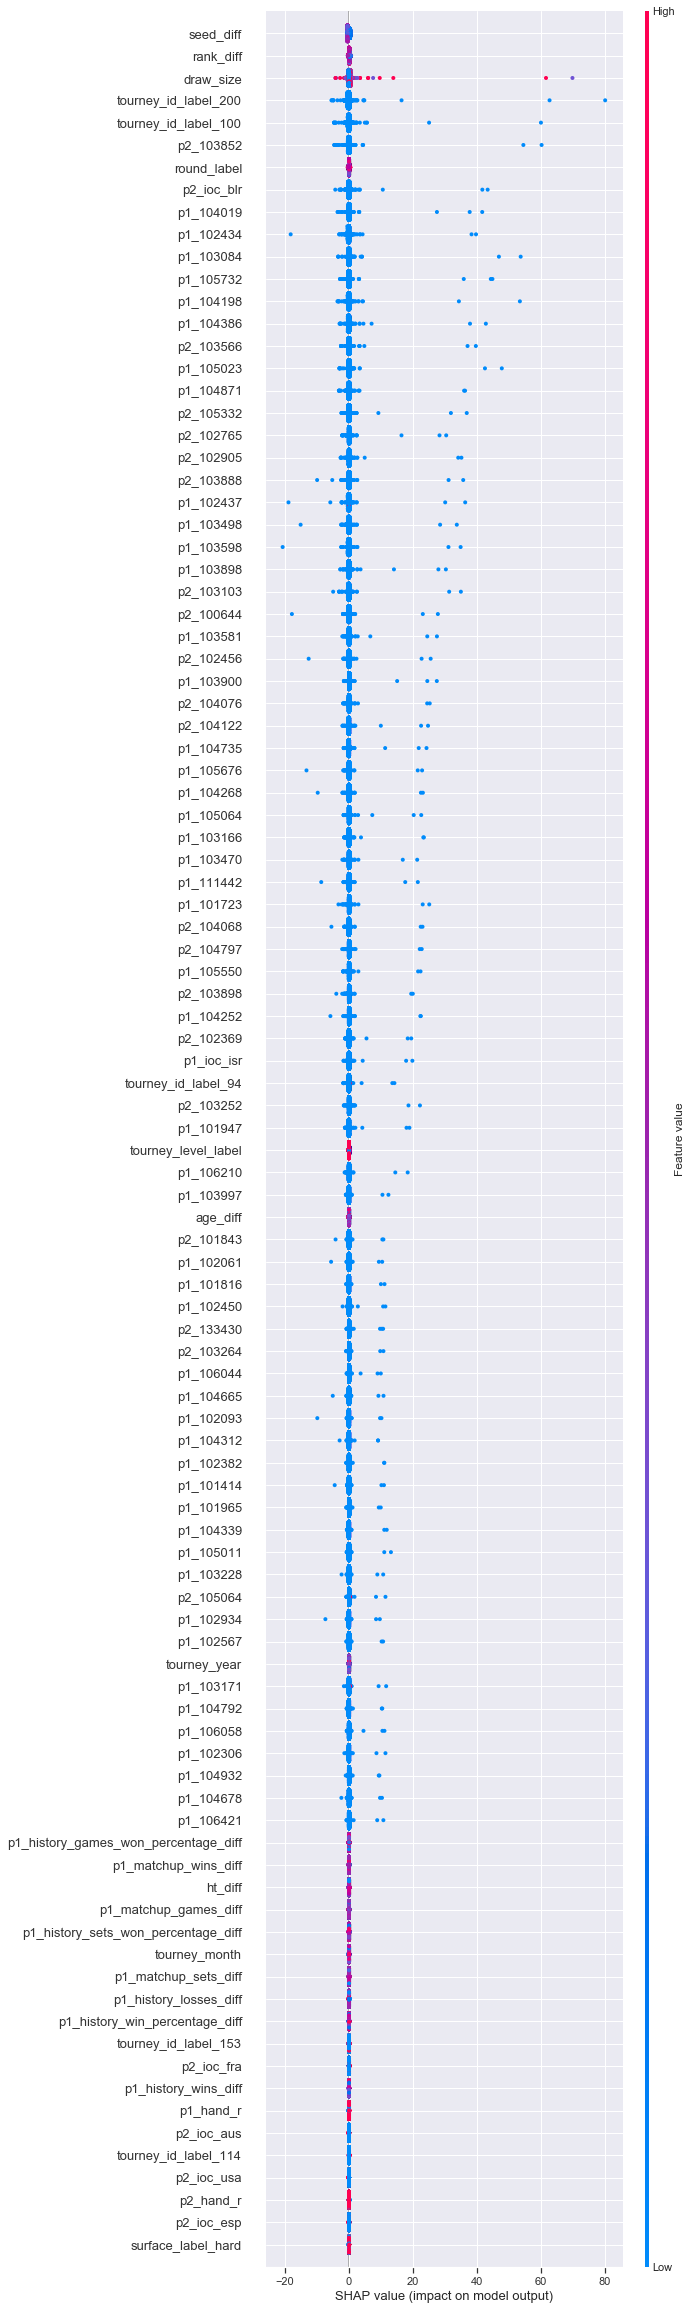

In [33]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=100)

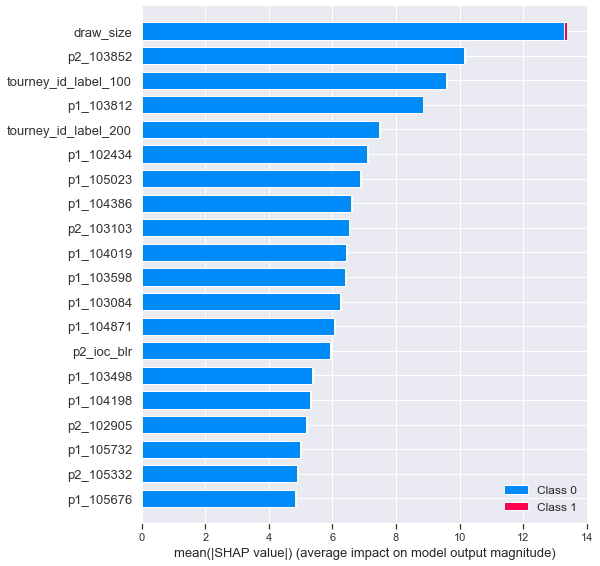

In [34]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, title="Feature Importance")

In [35]:
import util
import util.mapping_util as mu

import importlib
importlib.reload(util.mapping_util)

import logging
logging.basicConfig(level=logging.INFO)

mu.Mapper.get_player_info_by_id('p2_103852')

INFO:util.mapping_util:player_id: ['103852']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 12 columns):
id              2503 non-null object
name            2503 non-null object
ht              1654 non-null float64
hand            2503 non-null object
ioc             2503 non-null object
wins            2503 non-null int64
losses          2503 non-null int64
matches         2503 non-null int64
pro_date        2503 non-null object
retire_date     2503 non-null object
years_as_pro    2503 non-null int64
birthday        2503 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 234.8+ KB


,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
688,103852,feliciano lopez,188.0,L,ESP,472,424,896,1998-04-13,2019-02-25,21,1981-09-28
